In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

import random
import time
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.decoding import cross_val_multiscore
from mne import Epochs, create_info, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from typing import Union
from utils.beep import Beeper
from sklearn.base import BaseEstimator
from abc import ABC, abstractmethod
from typing import Optional, Iterable, Generator, Callable
from mne import EpochsArray
from collections import UserDict, UserList
from combiners import EpochsCombiner
from mne.decoding import SlidingEstimator
from sklearn.metrics import accuracy_score
from sklearn.base import ClassifierMixin, RegressorMixin
from utils.machine_learning import AbstractTransformer
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from utils.machine_learning.plotting import binary_dicision_boundary
from utils.data_management import dict2str
from sklearn.model_selection import train_test_split

In [3]:
from typing import Any
import pickle
import logging
logging.getLogger(__name__).setLevel(logging.CRITICAL)
logging.getLogger('mne').setLevel(logging.CRITICAL)

def read_pkl(path: str) -> Any:
    content = pickle.load(
        open(
            path,
            'rb'
        )
    )
    return content

# speakers
# sad_beep = Beeper(duration=[.1, .15, .25], frequency=[280, 240, 190], repeat=3)
# happy_beep = Beeper(duration=[.1, .1, .15, .25], frequency=[400, 370, 470, 500], repeat=4)
sad_beep = lambda: print('sad_beep')
happy_beep = lambda: print('happy_beep')

# paths
content_root = '../'
subjects_folder_path = os.path.join(content_root, 'Source/Subjects')
subject_path = os.path.join(subjects_folder_path, 'Az_Mar_05')
# info_path = os.path.join(subject_path, 'Info', 'ML_Subject05_P1_tsss_mc_trans_info.pkl')
resp_lock_lm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_LM_B1_epochs.fif')
resp_lock_rm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_RM_B1_epochs.fif')
resp_lock_li_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_LI_B1_epochs.fif')
resp_lock_ri_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_RI_B1_epochs.fif')

# readers
# original_info = read_pkl(info_path)
resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)
resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)
resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)

# combiner

# classes
first_class_indices = (0, 1)
second_class_indices = (2, 3)

In [28]:

combiner = EpochsCombiner(
    resp_lock_lm_B1_epochs,
    resp_lock_li_B1_epochs,
    resp_lock_rm_B1_epochs,
    resp_lock_ri_B1_epochs
).combine((0, 1), (2, 3), shuffle=True)

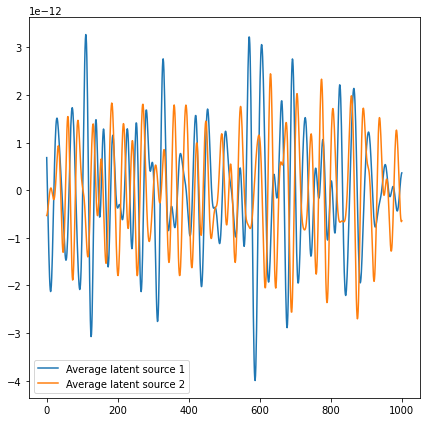

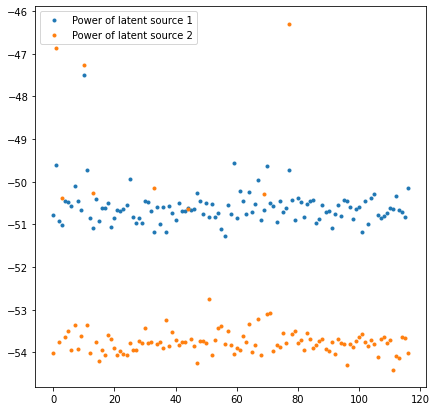

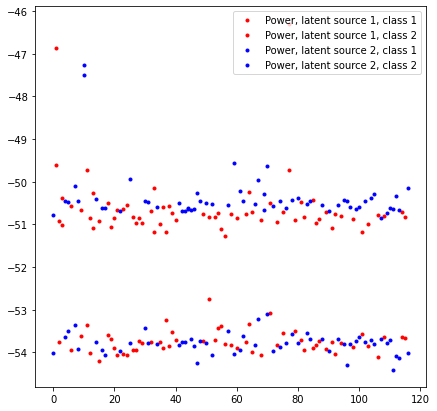

In [116]:

combiner = EpochsCombiner(
    resp_lock_lm_B1_epochs,
    resp_lock_li_B1_epochs,
    resp_lock_rm_B1_epochs,
    resp_lock_ri_B1_epochs
).filter(20, 40).combine((0, 1), (2, 3), shuffle=True)

# combiner = EpochsCombiner(
#     resp_lock_lm_B1_epochs,
#     resp_lock_li_B1_epochs,
# ).combine(0, 1, shuffle=True)

csp = CSP(
    n_components=2,
    reg='ledoit_wolf',
    rank= 'info',
    component_order='alternate',
    norm_trace=True,
    transform_into='csp_space'
)

X = combiner.X.copy()
Y = combiner.Y.copy()

X = csp.fit_transform(X, Y) 

plt.plot(X.mean(axis=0).T)
plt.legend(['Average latent source 1', 'Average latent source 2'])
plt.show()

power = np.log((X ** 2).mean(axis=2))
plt.plot(power[:, 0], '.', power[:, 1], '.',)
plt.legend(['Power of latent source 1', 'Power of latent source 2'])
plt.show()


class1_source1_power = np.array([p if y else np.NaN for p, y in zip(power[:, 0], Y)])
class2_source1_power = np.array([p if not y else np.NaN for p, y in zip(power[:, 0], Y)])
class1_source2_power = np.array([p if y else np.NaN for p, y in zip(power[:, 1], Y)])
class2_source2_power = np.array([p if not y else np.NaN for p, y in zip(power[:, 1], Y)])

not_Y = np.array([int(not y) for y in Y])
plt.plot(class1_source1_power, 'r.', class1_source2_power, 'r.', class2_source1_power, 'b.', class2_source2_power, 'b.')
plt.legend(['Power, latent source 1, class 1', 'Power, latent source 1, class 2', 'Power, latent source 2, class 1', 'Power, latent source 2, class 2'])
plt.show()


(87, 2) (30, 2)


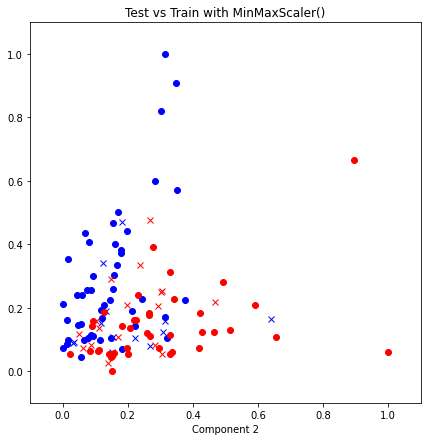

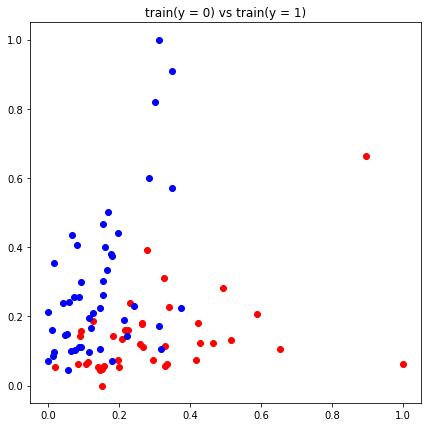

Score (avg, 100, MinMaxScaler()) between train(y = 0) and train(y = 1)
Must be differ, (The less, the better):
(0.00035391181835231895, array([7.02160210e-05, 6.37607616e-04]))
Good


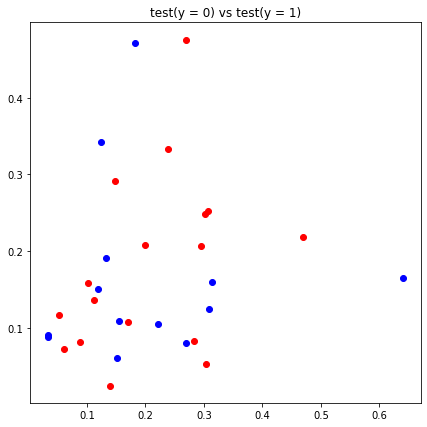

Score (avg, 100, MinMaxScaler()) between test(y = 0) and test(y = 1)
Must be differ, (The less, the better):
(0.7515901838174841, array([0.81979808, 0.68338229]))
Bad


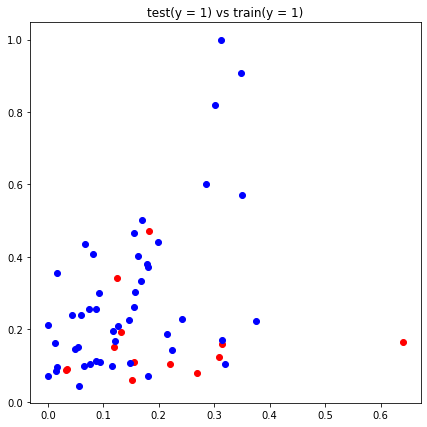

Score (avg, 100, MinMaxScaler()) between test(y = 1) and train(y = 1)
Must not be differ, (The more, the better):
(0.21443657725825954, array([0.29975249, 0.12912067]))
Good


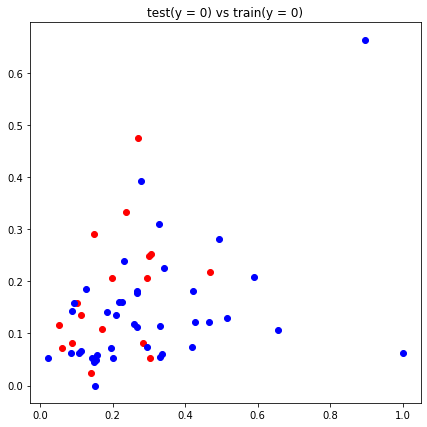

Score (avg, 100, MinMaxScaler()) between test(y = 0) and train(y = 0)
Must not be differ, (The more, the better):
(0.2794984247322219, array([0.18154318, 0.37745367]))
Good


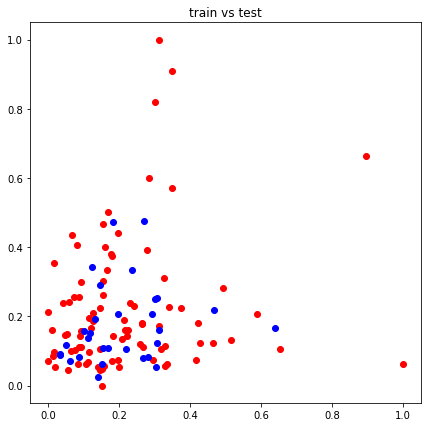

Score (avg, 100, MinMaxScaler()) between train and test
Must not be differ, (The more, the better):
(0.4673128765005383, array([0.60155577, 0.33306999]))
Good


In [66]:
from scipy import signal
from numpy.fft import fftfreq, fftshift
from scipy.fft import fft
from utils.console.colored import alarm, success
from scipy.stats.mstats_basic import ttest_ind
import scipy as sp
from sklearn.decomposition import PCA
from sklearn import linear_model as lm
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.cluster import KMeans

# csp = CSP(n_components=2, reg='shrinkage', rank='full')
# csp = CSP(n_components=2, reg='shrinkage', rank='info', component_order='alternate')
csp = CSP(
    n_components=2,
    reg='ledoit_wolf',
    rank= 'info',
    component_order='alternate',
    norm_trace=True
)

csp.plot_patterns

X = combiner.X.copy()
Y = combiner.Y.copy()
x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True)
x_train_csp = csp.fit_transform(x_train, y_train)
x_test_csp = csp.transform(x_test)

print(x_train_csp.shape, x_test_csp.shape)

plt.rcParams["figure.figsize"] = (7, 7)

# Explore Scalers

class NoneScaler(object):
    def __str__(self):
        return 'No Scaler'

for Scaler in [
    # None,
    # StandardScaler,
    # RobustScaler,
    MinMaxScaler,
    # MaxAbsScaler
]:
    x_train = x_train_csp.copy()
    x_test = x_test_csp.copy()
    if Scaler is not None:
        scaler = Scaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
    else:
        scaler = NoneScaler()

    plt.title(f'Test vs Train with {scaler}')
    plt.xlabel('Component 1')
    plt.xlabel('Component 2')
    plt.plot(
        x_train[:, 0][y_train==1], x_train[:, 1][y_train==1], 'ob',
        x_test[:, 0][y_test==1], x_test[:, 1][y_test==1], 'xb',
        x_train[:, 0][y_train==0], x_train[:, 1][y_train==0], 'or',
        x_test[:, 0][y_test==0], x_test[:, 1][y_test==0], 'xr',
    )
    plt.xlim(-.1, 1.1)
    plt.ylim(-.1, 1.1)
    plt.show()

    for test_group1, test_group2, group1_name, group2_name, comment in zip(
            (
                x_train[y_train==0],
                x_test[y_test==0],
                x_test[y_test==1],
                x_test[y_test==0],
                x_train,
            ),
            (
                x_train[y_train==1],
                x_test[y_test==1],
                x_train[y_train==1],
                x_train[y_train==0],
                x_test,
            ),
            (
                'train(y = 0)',
                'test(y = 0)',
                'test(y = 1)',
                'test(y = 0)',
                'train',
            ),
            (
                'train(y = 1)',
                'test(y = 1)',
                'train(y = 1)',
                'train(y = 0)',
                'test',
            ),
            (
                'Must be differ, (The less, the better)',
                'Must be differ, (The less, the better)',
                'Must not be differ, (The more, the better)',
                'Must not be differ, (The more, the better)',
                'Must not be differ, (The more, the better)',
            )
    ):
        plt.plot(
            test_group1[:, 0], test_group1[:, 1], 'or',
            test_group2[:, 0], test_group2[:, 1], 'ob'
        )
        plt.title(f'{group1_name} vs {group2_name}')
        plt.show()
        scores = list()
        n_iters = 100
        for i in range(n_iters):
            if test_group1.shape[0] > test_group2.shape[0]:
                np.random.shuffle(test_group1)
                group1 = test_group1[:test_group2.shape[0], :]
                group2 = test_group2
            else:
                group1 = test_group1
                np.random.shuffle(test_group2)
                group2 = test_group2[:test_group1.shape[0], :]
            stat, pval = ttest_ind(group1, group2, axis=0)
            scores.append(pval)
        print(
            f'Score (avg, {n_iters}, {scaler}) between {group1_name} and {group2_name}\n{comment}:'
            f'\n{np.array(scores).mean(axis=0).mean(), np.array(scores).mean(axis=0)}'
        )
        if comment == 'Must be differ, (The less, the better)':
            if any([score <= .1 for score in np.array(scores).mean(axis=0)]):
                print('Good')
            else:
                print('Bad')
        else:
            if any([score <= .1 for score in np.array(scores).mean(axis=0)]):
                print('Bad')
            else:
                print('Good')

/home/user/PycharmProjects/FingerMovementDecoder/utils/machine_learning/plotting.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(true_mesh), np.array(false_mesh)


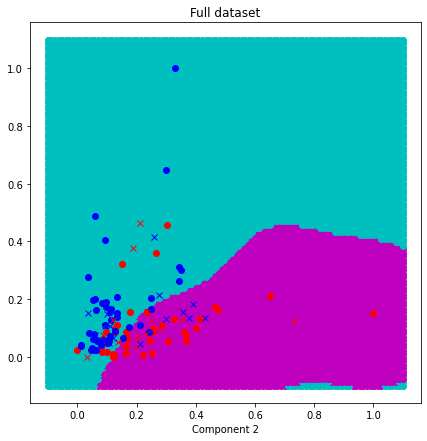

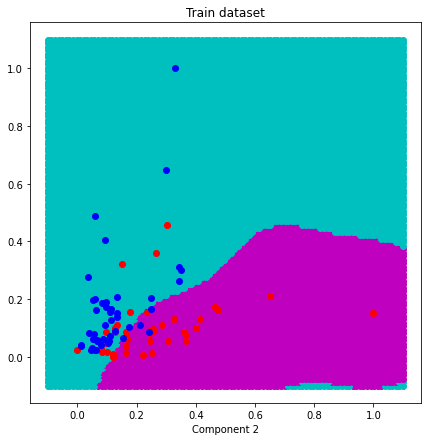

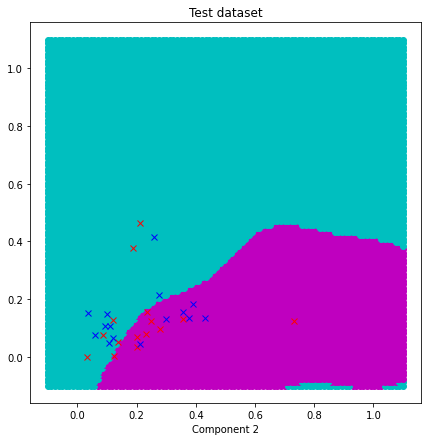

Train accuracy (n_components = 2): 0.7931034482758621
Test accuracy (n_components = 2): 0.6


In [32]:
x_train = x_train_csp.copy()
x_test = x_test_csp.copy()
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MinMaxScaler()
# scaler = MaxAbsScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# plt.plot(x_test, 'o')
# plt.show()
clf = svm.SVC(C=.7, kernel='rbf')
# clf = LogisticRegression()
# clf = MLPClassifier(
#             (200, 100, 50, 25),
#             max_iter=500,
#             early_stopping=True,
#             activation='relu',
#             solver='adam',
#             learning_rate='invscaling',
#             learning_rate_init = 1e-2,
#             alpha=1e-3,
#             warm_start=True,
#             momentum=.99
#         )
clf.fit(x_train, y_train)

true_mesh, false_mesh = binary_dicision_boundary(clf, np.linspace(-0.1, 1.1, 100))
# full dataset with train/test

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )
plt.plot(
    x_train[:, 0][y_train==0], x_train[:, 1][y_train==0], 'or',
    x_train[:, 0][y_train==1], x_train[:, 1][y_train==1], 'ob',
    x_test[:, 0][y_test==0], x_test[:, 1][y_test==0], 'xr',
    x_test[:, 0][y_test==1], x_test[:, 1][y_test==1], 'xb'
)
plt.title('Full dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.show()


for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )
plt.plot(
    x_train[:, 0][y_train==0], x_train[:, 1][y_train==0], 'or',
    x_train[:, 0][y_train==1], x_train[:, 1][y_train==1], 'ob'
)
plt.title('Train dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.show()

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )
plt.plot(
    x_test[:, 0][y_test==0], x_test[:, 1][y_test==0], 'xr',
    x_test[:, 0][y_test==1], x_test[:, 1][y_test==1], 'xb'
)
plt.title('Test dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.show()

print(f'Train accuracy (n_components = 2): {clf.score(x_train, y_train)}')
print(f'Test accuracy (n_components = 2): {clf.score(x_test, y_test)}')

In [201]:
# csp = CSP(n_components=3, reg='shrinkage', rank='info', component_order='alternate')
csp = CSP(
    n_components=3,
    reg='ledoit_wolf',
    rank='info',
    component_order='mutual_info',
    norm_trace=True
)
clf = svm.SVC(C=.7, kernel='rbf')
# clf = LogisticRegression()
# clf = MLPClassifier(
#             (100, 50, 10),
#             max_iter=500,
#             early_stopping=True,
#             activation='relu',
#             solver='adam',
#             learning_rate='constant',
#             learning_rate_init = 0.05,
#             alpha=.005,
#             warm_start=True,
#             momentum=.99
#         )
X = combiner.X.copy()
Y = combiner.Y.copy()
x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True)
x_train = csp.fit_transform(x_train, y_train)
x_test = csp.transform(x_test)
clf.fit(x_train, y_train)
print(f'Train accuracy (n_components = 3): {clf.score(x_train, y_train)}')
print(f'Test accuracy (n_components = 3): {clf.score(x_test, y_test)}')

Train accuracy (n_components = 3): 0.7126436781609196
Test accuracy (n_components = 3): 0.3333333333333333


In [202]:
# csp = CSP(n_components=3, reg='shrinkage', rank='info', component_order='alternate')
csp = CSP(
    n_components=4,
    reg='ledoit_wolf',
    rank='info',
    component_order='alternate',
    norm_trace=True
)
clf = svm.SVC(C=.7, kernel='rbf')
# clf = LogisticRegression()
# clf = MLPClassifier(
#             (200, 150, 100, 25),
#             max_iter=500,
#             early_stopping=True,
#             activation='relu',
#             solver='adam',
#             learning_rate='constant',
#             learning_rate_init = 0.05,
#             alpha=.005,
#             warm_start=True,
#             momentum=.99
#         )
X = combiner.X.copy()
Y = combiner.Y.copy()
x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True)
x_train = csp.fit_transform(x_train, y_train)
x_test = csp.transform(x_test)
clf.fit(x_train, y_train)
print(f'Train accuracy (n_components = 4): {clf.score(x_train, y_train)}')
print(f'Test accuracy (n_components = 4): {clf.score(x_test, y_test)}')

Train accuracy (n_components = 4): 0.5747126436781609
Test accuracy (n_components = 4): 0.43333333333333335


In [ ]:
plt.title('Test vs Train y == 1')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.plot(
    x_train[:, 0][y_train==1], x_train[:, 1][y_train==1], 'ob',
    x_test[:, 0][y_test==1], x_test[:, 1][y_test==1], 'xb',
    x_train[:, 0][y_train==0], x_train[:, 1][y_train==0], 'or',
    x_test[:, 0][y_test==0], x_test[:, 1][y_test==0], 'xr',
)
plt.show()
plt.title('Test vs Train y == 0')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.plot(
    x_train[:, 0][y_train==0], x_train[:, 1][y_train==0], 'or',
    x_test[:, 0][y_test==0], x_test[:, 1][y_test==0], 'xr',
)
plt.show()
plt.title('Test vs Train y == 1')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.plot(
    x_train[:, 0][y_train==1], x_train[:, 1][y_train==1], 'ob',
    x_test[:, 0][y_test==1], x_test[:, 1][y_test==1], 'xb'
)
plt.show()



In [ ]:
X = combiner.X
Y = combiner.Y
X_t = csp.fit_transform(X, Y)
print(X.shape)
n_components = 4
filters = csp.filters_[:n_components]
X_t = np.array([filters@epoch for epoch in X])
print(X_t.shape)

ch_names = [f'L{i+1}' for i in range(n_components)]
ch_types = ['mag'] * n_components
sampling_freq = 1000
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.normalize_proj()
latent_epochs = mne.EpochsArray(X_t, info)
latent_epochs.plot(
    scalings='auto'
)
# latent_epochs = mne.EpochsArray(X, resp_lock_li_B1_epochs.info)
# latent_epochs.plot()

In [ ]:
plt.plot(X_t[0, 0, :])

In [ ]:
from utils.machine_learning.plotting import DistributionPlotter


train_acc, test_acc = list(), list()
for _ in range(1):
    # X = csp.fit_transform(combiner.X, combiner.Y)
    X = combiner.X
    Y = combiner.Y
    # X = X[:, [0, 1, 2, 3, 4, 6]]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True)
    print(X.shape)
    clf = make_pipeline(
        CSP(
            n_components=2,
            reg='shrinkage',
            rank='full',
            # component_order='alternate'
        ),
        DistributionPlotter(scale=np.linspace(-3, 3, 1000)),
        # Selector(),
        LogisticRegression(penalty='l1', solver='saga')
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    scores = cross_val_score(
                estimator=clf,
                X=combiner.X,
                y=combiner.Y,
                scoring='roc_auc',
                cv=cv,
                n_jobs=1,
            )
    print(f'*****************\nscores: {scores}\nmean: {np.mean(scores)}')

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    train_acc.append(clf.score(x_train, y_train))
    test_acc.append(accuracy_score(y_test, y_pred))
print(f'train accuracy = {np.array(train_acc).mean()}')
print(f'test accuracy = {np.array(test_acc).mean()}')

In [ ]:
# clf = make_pipeline(
#     CSP(
#         n_components=2,
#         reg='shrinkage',
#         rank='full'
#     ),
#     LogisticRegression(penalty='l1', solver='saga')
# )


train_acc, test_acc = list(), list()
for _ in range(1):
    x_train, x_test, y_train, y_test =  combiner.train_test_split(shuffle=True)
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    clf = make_pipeline(
        CSP(
            n_components=2,
            reg='shrinkage',
            rank='full',
            component_order='alternate'
        ),
        # Selector(),
        # MLPClassifier(
        #     (100, 50, 10),
        #     max_iter=500,
        #     early_stopping=True,
        #     activation='relu',
        #     solver='adam',
        #     learning_rate='constant',
        #     learning_rate_init = 0.05,
        #     alpha=.005,
        #     warm_start=True,
        #     momentum=.99
        # )
        LogisticRegression(),
    )
    print(combiner.X.shape)
    scores = cross_val_score(
                estimator=clf,
                X=combiner.X,
                y=combiner.Y,
                scoring='roc_auc',
                cv=cv,
                n_jobs=1,
            )
    print(f'*****************\nscores: {scores}\nmean: {np.mean(scores)}')

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    train_acc.append(clf.score(x_train, y_train))
    test_acc.append(accuracy_score(y_test, y_pred))
print(f'Train accuracy = {np.array(train_acc).mean() : .2f}')
print(f'Test accuracy = {np.array(test_acc).mean() : .2f}')

In [ ]:
print(combiner._EpochsCombiner__storage)


In [ ]:
# csp -> train_test_split -> classifier

csp = CSP(
            n_components=2,
            reg='shrinkage',
            rank='full',
        )

clf = LogisticRegression()

Y = combiner.Y
X = combiner.X
print(X.shape)
p = np.random.permutation(Y.shape[0])
Y = Y[p]
X = X[p, :, :]
X = csp.fit_transform(X, Y)
print(X.shape)

x_train_csp, x_test_csp, y_train, y_test = train_test_split(X, Y, shuffle=True)
clf.fit(x_train_csp, y_train)

print(f'train accuracy = {clf.score(x_train_csp, y_train)}')
print(f'test accuracy = {accuracy_score(y_test, clf.predict(x_test_csp))}')

In [ ]:
# train_test_split -> csp -> classifier

combiner = EpochsCombiner(
    resp_lock_lm_B1_epochs,
    resp_lock_li_B1_epochs,
    resp_lock_rm_B1_epochs,
    resp_lock_ri_B1_epochs
).filter(l_freq=25., h_freq=30.)\
    .crop(tmin=.0, tmax=.3)\
    .combine((0, 1), (2, 3), shuffle=True)

csp = CSP(
            n_components=2,
            reg='shrinkage',
            rank='full',
            # component_order='alternate'
        )

# clf = LogisticRegression()

# Optimized model
clf1 = MLPClassifier(
            (100, 50, 10),
            max_iter=1000,
            # early_stopping=True,
            activation='relu',
            solver='adam',
            learning_rate='invscaling',
            # learning_rate_init = 0.05,
            # alpha=.005,
            # momentum=.99
        )

clf2 = LogisticRegression()

X = combiner.X
Y = combiner.Y

x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, train_size=.8)

x_train_csp = csp.fit_transform(x_train, y_train)
# filters1 = csp.filters_
x_test_csp = csp.transform(x_test)
# print(filters1 == csp.filters_)
clf1.fit(x_train_csp, y_train)
clf2.fit(x_train_csp, y_train)


x_train_csp_class1 = x_train_csp[y_train == 0]
x_train_csp_class2 = x_train_csp[y_train == 1]
x_test_csp_class1 = x_test_csp[y_test == 0]
x_test_csp_class2 = x_test_csp[y_test == 1]

true_mesh, false_mesh = binary_dicision_boundary(clf1, np.linspace(-3, 3, 100))
# full dataset with train/test

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )


plt.plot(
    x_train_csp_class1[:, 0], x_train_csp_class1[:, 1], 'or',
    x_train_csp_class2[:, 0], x_train_csp_class2[:, 1], 'ob'
)
plt.plot(
    x_test_csp_class1[:, 0], x_test_csp_class1[:, 1], 'xr',
    x_test_csp_class2[:, 0], x_test_csp_class2[:, 1], 'xb'
)
plt.title('Full dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# train dataset

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )


plt.plot(
    x_train_csp_class1[:, 0], x_train_csp_class1[:, 1], 'or',
    x_train_csp_class2[:, 0], x_train_csp_class2[:, 1], 'ob'
)
plt.title('Train dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# test dataset

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )

plt.plot(
    x_test_csp_class1[:, 0], x_test_csp_class1[:, 1], 'xr',
    x_test_csp_class2[:, 0], x_test_csp_class2[:, 1], 'xb'
)
plt.title('Test dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()


print(f'train accuracy = {clf1.score(x_train_csp, y_train)}')
print(f'test accuracy = {accuracy_score(y_test, clf1.predict(x_test_csp))}')

true_mesh, false_mesh = binary_dicision_boundary(clf2, np.linspace(-3, 3, 100))
# full dataset with train/test

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )


plt.plot(
    x_train_csp_class1[:, 0], x_train_csp_class1[:, 1], 'or',
    x_train_csp_class2[:, 0], x_train_csp_class2[:, 1], 'ob'
)
plt.plot(
    x_test_csp_class1[:, 0], x_test_csp_class1[:, 1], 'xr',
    x_test_csp_class2[:, 0], x_test_csp_class2[:, 1], 'xb'
)
plt.title('Full dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# train dataset

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )


plt.plot(
    x_train_csp_class1[:, 0], x_train_csp_class1[:, 1], 'or',
    x_train_csp_class2[:, 0], x_train_csp_class2[:, 1], 'ob'
)
plt.title('Train dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# test dataset

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )

plt.plot(
    x_test_csp_class1[:, 0], x_test_csp_class1[:, 1], 'xr',
    x_test_csp_class2[:, 0], x_test_csp_class2[:, 1], 'xb'
)
plt.title('Test dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()


print(f'train accuracy = {clf2.score(x_train_csp, y_train)}')
print(f'test accuracy = {accuracy_score(y_test, clf2.predict(x_test_csp))}')

In [ ]:
csp = CSP(
            n_components=10,
            reg='shrinkage',
            rank='full',
            # component_order='alternate'
        )

X = combiner.X
Y = combiner.Y

x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, train_size=.8)

x_train_csp = csp.fit_transform(x_train, y_train)
# filters1 = csp.filters_
x_test_csp = csp.transform(x_test)

csp.plot_patterns(resp_lock_li_B1_epochs.info, ch_type='grad', units='Patterns (AU)', size=1.5)

print(csp)

In [ ]:
test_acc, train_acc = list(), list()

for _ in range(100):
    csp = CSP(
                n_components=2,
                reg='shrinkage',
                rank='full',
                # component_order='alternate'
            )

    # clf = LogisticRegression()

    # Optimized model
    clf = MLPClassifier(
                (100, 50, 10),
                max_iter=1000,
                # early_stopping=True,
                activation='relu',
                solver='adam',
                learning_rate='invscaling',
                # learning_rate_init = 0.05,
                # alpha=.005,
                # momentum=.99
            )

    X = combiner.X
    Y = combiner.Y

    x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, train_size=.8)

    x_train_csp = csp.fit_transform(x_train, y_train)
    # filters1 = csp.filters_
    x_test_csp = csp.transform(x_test)
    # print(filters1 == csp.filters_)
    clf.fit(x_train_csp, y_train)
    train_acc.append(clf.score(x_train_csp, y_train))
    test_acc.append(accuracy_score(y_test, clf.predict(x_test_csp)))

print(f'train accuracy = {np.mean(np.array(train_acc))}')
print(f'test accuracy = {np.mean(np.array(test_acc))}')

In [ ]:
test_acc, train_acc = list(), list()

for _ in range(100):
    csp = CSP(
                n_components=2,
                reg='shrinkage',
                rank='full',
                # component_order='alternate'
            )

    # clf = LogisticRegression()

    # Optimized model
    clf = MLPClassifier(
                (100, 50, 10),
                max_iter=1000,
                # early_stopping=True,
                activation='relu',
                solver='adam',
                learning_rate='invscaling',
                # learning_rate_init = 0.05,
                # alpha=.005,
                # momentum=.99
            )

    X = combiner.X
    Y = combiner.Y

    x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, train_size=.8)

    x_train_csp = csp.fit_transform(x_train, y_train)
    # filters1 = csp.filters_
    x_test_csp = csp.transform(x_test)
    # print(filters1 == csp.filters_)
    clf.fit(x_train_csp, y_train)
    train_acc.append(clf.score(x_train_csp, y_train))
    test_acc.append(accuracy_score(y_test, clf.predict(x_test_csp)))

print(f'train accuracy = {np.mean(np.array(train_acc))}')
print(f'test accuracy = {np.mean(np.array(test_acc))}')